In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

# Halo Shapes

In [2]:
basePath = '/Volumes/G-RAID/simulations/unprocessed/Illustris/Illustris-1'
snapNum = 135
m_dm = 6.3*10**6.0 #dark matter particle mass
little_h = 0.704
Lbox = np.array([75.0]*3)

ptcl_type = {'gas':0,
             'dark-matter':1,
             'tracers':3,
             'stars/wind':4,
             'black holes':5}

In [3]:
from illustris_python.snapshot import loadHalo, snapPath, loadSubhalo
from illustris_python.groupcat import gcPath, loadHalos, loadSubhalos

halo_positions = loadHalos(basePath, snapNum, fields=['GroupPos'])/1000.0

IOError: Unable to open file (unable to open file: name = '/Volumes/G-RAID/simulations/unprocessed/Illustris/Illustris-1/groups_135/fof_subhalo_tab_135.0.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
halo_id = 0

# load position
halo_positions = loadHalos(basePath, snapNum, fields=['GroupPos'])/1000.0
halo_position = halo_positions[halo_id]

# load particles
ptcl_coords = loadHalo(basePath, snapNum, gal_id, 1, fields=['Coordinates'])/1000.0

# load halo size
halo_sizes = loadHalos(basePath, snapNum, fields=['Group_R_Mean200'])/1000.0
halo_size = halo_sizes[halo_id]

# account for PBCs
dx = ptcl_coords[:,0] - halo_position[0]
dy = ptcl_coords[:,1] - halo_position[1]
dz = ptcl_coords[:,2] - halo_position[2]

mask = (dx > Lbox[0]/2.0)
dx[mask] = dx[mask] - Lbox[0]
mask = (dx < -Lbox[0]/2.0)
dx[mask] = dx[mask] + Lbox[0]

mask = (dy > Lbox[1]/2.0)
dy[mask] = dy[mask] - Lbox[1]
mask = (dy < -Lbox[1]/2.0)
dy[mask] = dy[mask] + Lbox[1]

mask = (dz > Lbox[2]/2.0)
dz[mask] = dz[mask] - Lbox[2]
mask = (dz < -Lbox[2]/2.0)
dz[mask] = dz[mask] + Lbox[2]

ptcl_coords = np.vstack((dx,dy,dz)).T

I = reduced_inertia_tensors(ptcl_coords)

evals, evecs = np.linalg.eigh(I)
evals = np.sqrt(evals)

plt.figure()
plt.plot(ptcl_coords[mask,0], ptcl_coords[mask,1], '.', ms=1, alpha=0.2)
plt.xlim([-2*halo_size, 2*halo_size])
plt.ylim([-2*halo_size, 2*halo_size])
plt.show()

plt.figure()
plt.plot(ptcl_coords[mask,1], ptcl_coords[mask,2], '.', ms=1, alpha=0.2)
plt.xlim([-2*halo_size, 2*halo_size])
plt.ylim([-2*halo_size, 2*halo_size])
plt.show()

plt.figure()
plt.plot(ptcl_coords[:,0], ptcl_coords[:,1], '.', ms=1, alpha=0.2)
plt.xlim([-2*halo_size, 2*halo_size])
plt.ylim([-2*halo_size, 2*halo_size])
plt.show()

plt.figure()
plt.plot(ptcl_coords[:,1], ptcl_coords[:,2], '.', ms=1, alpha=0.2)
plt.xlim([-2*halo_size, 2*halo_size])
plt.ylim([-2*halo_size, 2*halo_size])
plt.show()

IOError: Unable to open file (unable to open file: name = '/Volumes/G-RAID/simulations/unprocessed/Illustris/Illustris-1/groups_135/fof_subhalo_tab_135.0.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## measured halo shapes

In [9]:
from astropy.table import Table
t_1 = Table.read('../data/halo_shapes_1.dat', format='ascii')

q = t_1['b']/t_1['a']
s = t_1['c']/t_1['a']

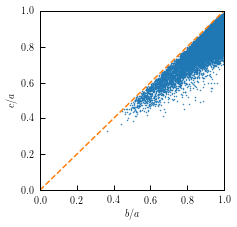

In [13]:
plt.figure(figsize=(3.3,3.3))
plt.plot(q, s, '.', ms=1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1], [0,1], '--')
plt.xlabel(r'$b/a$')
plt.ylabel(r'$c/a$')
plt.show()

## galaxy-halo shape correlations

In [15]:
from astropy.table import Table
t_1 = Table.read('../data/galaxy_shapes_1.dat', format='ascii')
t_2 = Table.read('../data/halo_shapes_1.dat', format='ascii')

In [17]:
t_2

halo_id,a,b,c,av_x,av_y,av_z,bv_x,bv_y,bv_z,cv_x,cv_y,cv_z
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.7362815072845351,0.5431545276840021,0.40357490145833647,-0.2608451210809999,0.1120254752318865,0.9588587569122519,-0.12246572187805509,0.9813798803240894,-0.1479718806394085,0.9575813123558361,0.15602507296632334,0.24226887301658911
1,0.7489652596542596,0.5080370197525045,0.4253815068757924,0.9671085820008156,-0.25424103078308014,0.007904991254173675,0.07502575383569364,0.2554202704166018,-0.9639147377863333,-0.2430475815180179,-0.9328032931581377,-0.266093760527329
2,0.6936492253282607,0.5406612705609529,0.47595813126474756,-0.18943385942674038,0.9779420396554978,-0.0880010225914145,0.8966395036153912,0.20881789131810533,0.390426291150845,0.40019047147456477,-0.004945234059639962,-0.9164186440710711
3,0.7244355697432237,0.562522559840466,0.3984488360645907,0.9607661062986509,-0.05654544231151739,0.2715347159048437,-0.1413068225943248,0.7426247737490369,0.6546302981855391,0.23866476672526535,0.6673163105814114,-0.7054984555305474
4,0.7060484200337883,0.539124927031978,0.4591731063775284,0.9031094900482346,0.3592102537739692,0.2352896992400172,-0.39500646882351337,0.9098409403654723,0.12711944313302875,0.16841359378742554,0.207743728710431,-0.9635763615869222
5,0.7264938601074133,0.5313894754299114,0.4356970238923945,0.7456708523603071,-0.40799885272055914,-0.5267939978008109,0.6490418277737198,0.6236021969446152,0.4357350178330848,-0.15073050699975155,0.6668262413436932,-0.7298103028287835
6,0.7049729654446526,0.5531536904231652,0.4438852472917543,0.5826323027692111,0.39467367065356296,-0.7104732883526936,0.41592461816466614,-0.8958225233039766,-0.15655260695968354,-0.6982451659513466,-0.2042907252768452,-0.6860896353913515
7,0.8976047531440969,0.32707279008321677,0.2955149693676682,-0.12607190001159763,0.9852446891840116,-0.11575309266782254,-0.9903712438431408,-0.13172928608099502,-0.04256987851968902,0.05718981898953166,-0.10927166889588165,-0.992365369700421
8,0.6250883425606885,0.5707073527596724,0.5325013441305092,-0.6048158433091557,0.21807843427601703,-0.7659240120181346,0.38741170458175456,0.9208692540991888,-0.04372628509103801,0.6957801138544377,-0.32317427706815455,-0.641442452450866
